In [2]:
import sys; sys.path.append("../")

from vle.utils import instantiate_from_config, load_config

import torchvision.transforms as transforms
import torchvision

from torch.utils.data import DataLoader
import torch.nn.functional as F

import torch

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [3]:
# base = "/fsx/home/johnathan/variable-length-embeddings/configs/single-image-test-config.yaml"
base = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T18-04-45_encoder-lstm-higher-position-bce/training_config_laion-11.yaml"
config = load_config(base)
model = instantiate_from_config(config["model"]).cuda()
dataset = instantiate_from_config(config["data"])
dataloader = dataset.train_dataloader()
batch = next(iter(dataloader)).cuda()

epsilon = 1e-4

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /fsx/home/johnathan/variable-length-embeddings/develop/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
AspectRatiosBatcher::cache_bins: [(512, 512), (576, 448), (448, 576), (704, 384), (384, 704)]
Loading webdataset with 98854 shards.


In [4]:
def lr_lambda_fn(step):
    return 0.95

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lr_lambda_fn)

lpips_loss = model.lpips_loss

def loss_fn(use_bce=False, use_lpips=False, use_aux=False, aux_mult=1.0, bce_mult=1e-3, lpips_mult=1e-1):
    def wrapped_fn(outputs, inputs, intermediates):
        n_tokens = len(intermediates)
        aux_loss, aux_bce_loss = 0.0, 0.0
        prev_i_rec = None
        rec = torch.zeros_like(inputs)
        for i_rec in intermediates["tokens"]:
            rec = rec + i_rec

            # Compute intermediate losses
            aux_loss += F.mse_loss(inputs, rec)
            if use_bce and prev_i_rec is not None:
                i_rec_norm = torch.abs(i_rec)
                i_rec_norm = i_rec_norm / (
                    torch.amax(i_rec_norm, dim=(-2, -1), keepdim=True) + epsilon
                )
                i_rec_norm = torch.clamp(i_rec_norm, epsilon, 1 - epsilon)

                rec_norm = torch.abs(rec)
                rec_norm = rec_norm / (
                    torch.amax(rec_norm, dim=(-2, -1), keepdim=True) + epsilon
                )
                rec_norm = torch.clamp(rec_norm, epsilon, 1 - epsilon)
                aux_bce_loss -= F.binary_cross_entropy(i_rec_norm, rec_norm)

            prev_i_rec = i_rec

        # Compute final losses
        p_loss = 0.0
        if use_lpips:
            p_loss = lpips_loss(inputs, rec).mean() * lpips_mult
        loss = F.mse_loss(inputs, rec)

        # Multiply bce loss by scalar
        aux_bce_loss *= bce_mult
        aux_loss *= aux_mult

        # Average intermediate losses
        aux_loss /= n_tokens
        aux_bce_loss /= n_tokens
        
        return loss, aux_loss, p_loss, aux_bce_loss
    return wrapped_fn

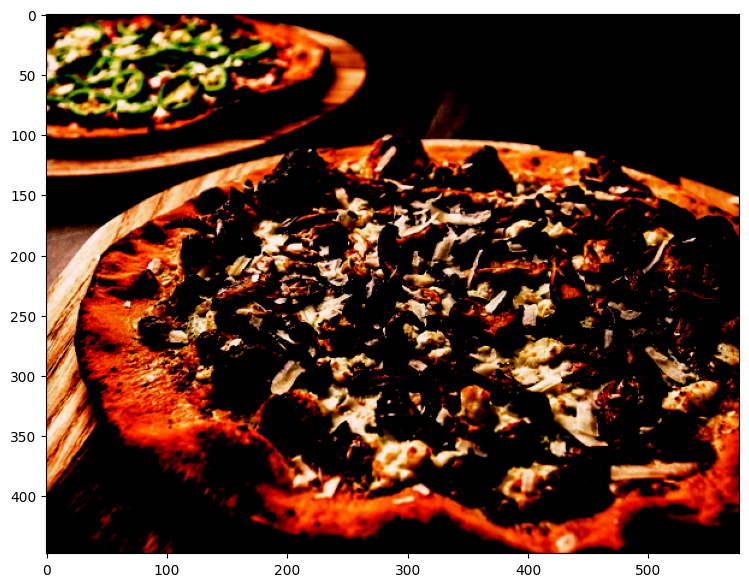

In [5]:
loss_metric = loss_fn(use_bce=True, use_lpips=True, use_aux=True, bce_mult=1e-1)
max_tokens = 4

example_idx = 3

postprocess = lambda x: np.clip((x.moveaxis(0, -1).cpu().detach().numpy() * 255), 0, 255).astype(int)
def training_loop(batch, iters=1000, print_every_n=100, lr_update=100, warmup_token_steps=None):
    for i in range(iters):
        n_tokens = np.random.randint(1, max_tokens + 1)
        optimizer.zero_grad()

        outputs, tokens = model(batch, n_tokens, ret_tokens=True)
        mse_loss, aux_loss, p_loss, aux_bce_loss = loss_metric(outputs, batch, tokens)
        
        if warmup_token_steps is not None:
            eps = min(i / warmup_token_steps, 0.5)
            mse_loss *= eps; aux_loss *= 1 - eps
        
        loss = mse_loss + aux_loss + p_loss + aux_bce_loss
        
        loss.backward()
        optimizer.step()
        if (i + 1) % lr_update == 0:
            lr_scheduler.step()
        
        if i % print_every_n == 0:
            print_statement = f"Iteration {i}: {loss:.5f} "
            print_statement += f"(mse: {mse_loss:.5f}, aux_loss: {aux_loss:.5f}, "
            print_statement += f"p_loss: {p_loss:.5f}, bce_loss: {aux_bce_loss:.5f})"
            print_statement += f", (lr: {lr_scheduler.get_lr()[0]})"
            print(print_statement)

            fig, axes = plt.subplots(3, n_tokens, figsize=(20, 7))
            rec = torch.zeros_like(batch)
            for j, token in enumerate(tokens["tokens"]):
                delta = token
                rec = rec + delta
                hm = np.linalg.norm(postprocess(delta[example_idx]), axis=-1)
                if n_tokens == 1:
                    axes[0].imshow(hm, cmap='hot'); axes[0].axis('off')
                    axes[1].imshow(postprocess(rec[example_idx])); axes[1].axis('off')
                    axes[2].hist((batch[example_idx] - rec[example_idx]).cpu().detach().numpy().flatten(), bins=50)
                else:                    
                    axes[0,j].imshow(hm, cmap='hot'); axes[0,j].axis('off')
                    axes[1,j].imshow(postprocess(rec[example_idx])); axes[1,j].axis('off')
                    axes[2,j].hist((batch[example_idx] - rec[example_idx]).cpu().detach().numpy().flatten(), bins=50)
            plt.show()
    
        del tokens
        
plt.figure(figsize=(20, 7))
plt.imshow(postprocess(batch[example_idx]))

plt.show()

Iteration 0: 0.94621 (mse: 0.00000, aux_loss: 0.97182, p_loss: 0.11934, bce_loss: -0.14494), (lr: 0.0003)


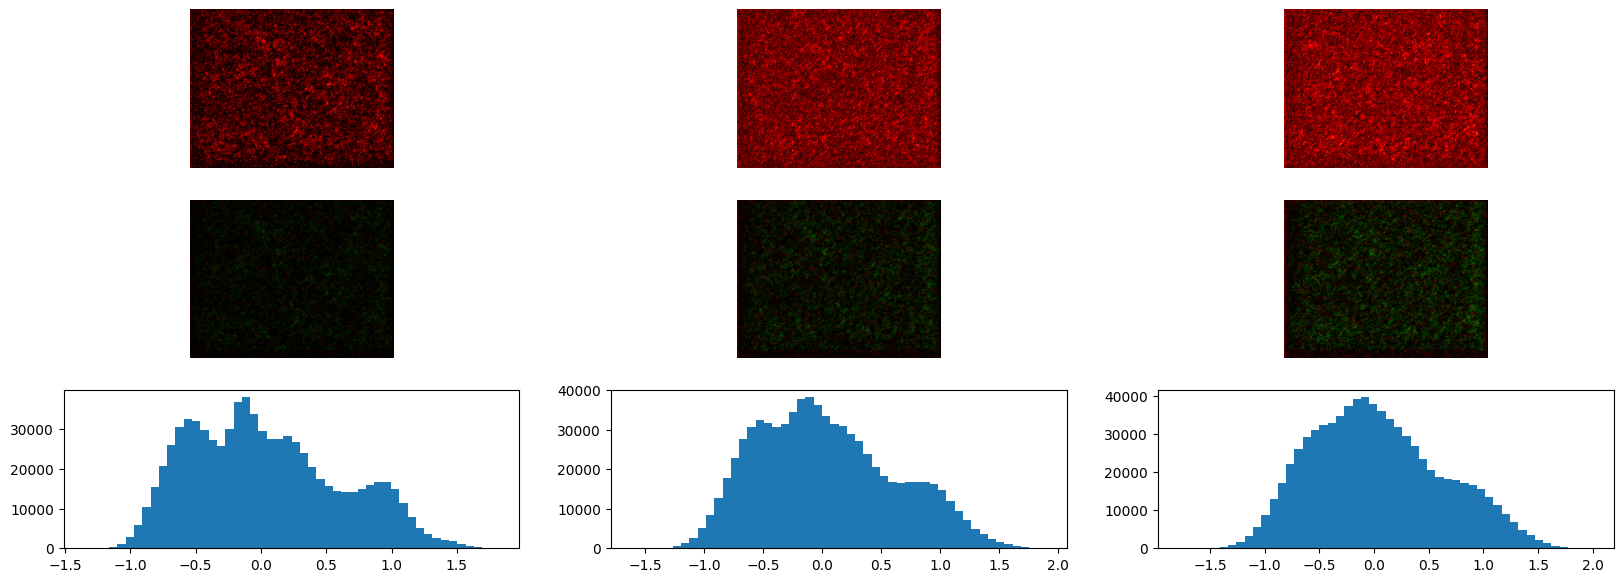

Iteration 100: 0.01904 (mse: 0.04956, aux_loss: 0.20374, p_loss: 0.06813, bce_loss: -0.30239), (lr: 0.0003)


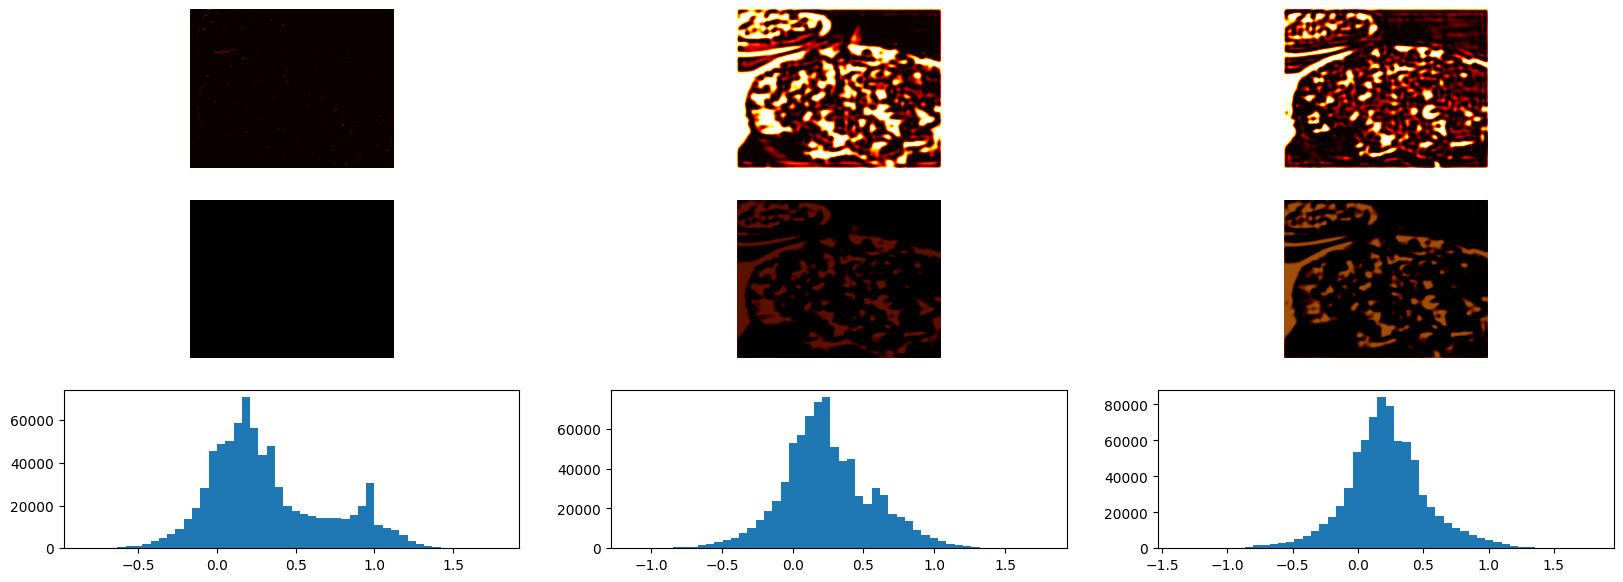

Iteration 200: -0.16666 (mse: 0.03886, aux_loss: 0.21978, p_loss: 0.06092, bce_loss: -0.48621), (lr: 0.00027075)


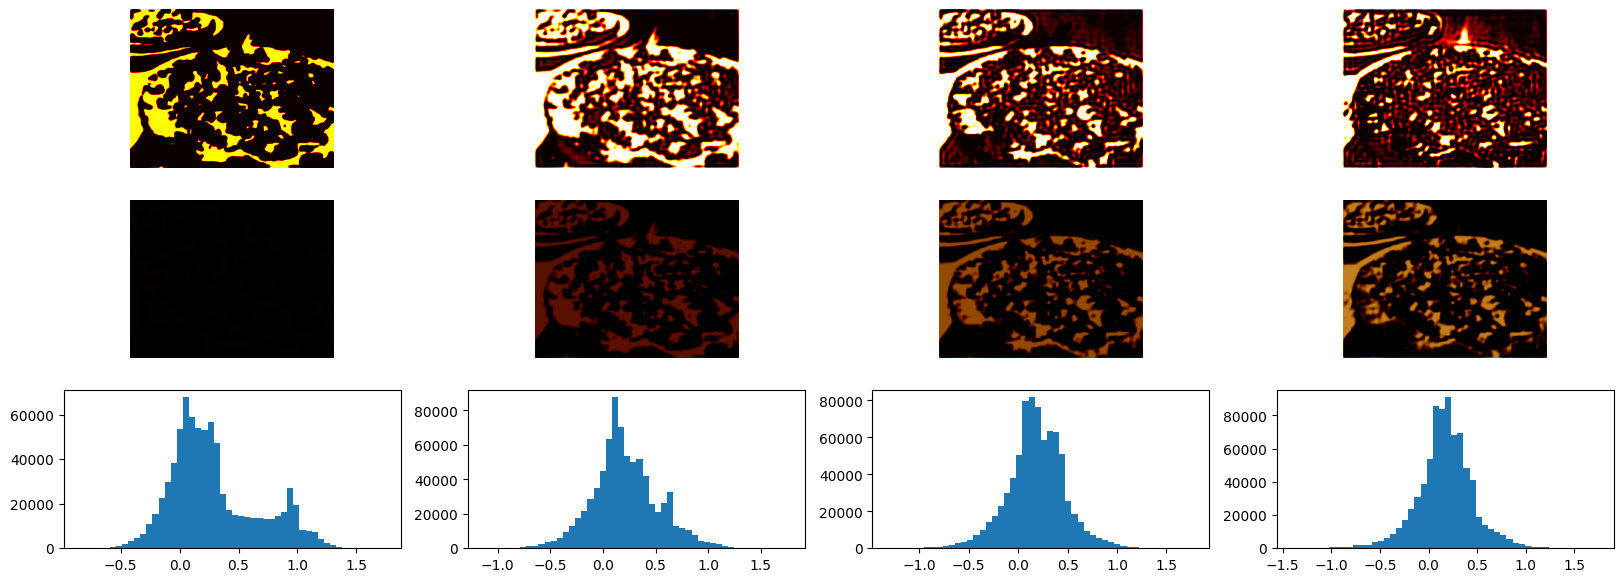

Iteration 300: 0.23768 (mse: 0.08769, aux_loss: 0.08769, p_loss: 0.06231, bce_loss: 0.00000), (lr: 0.00027075)


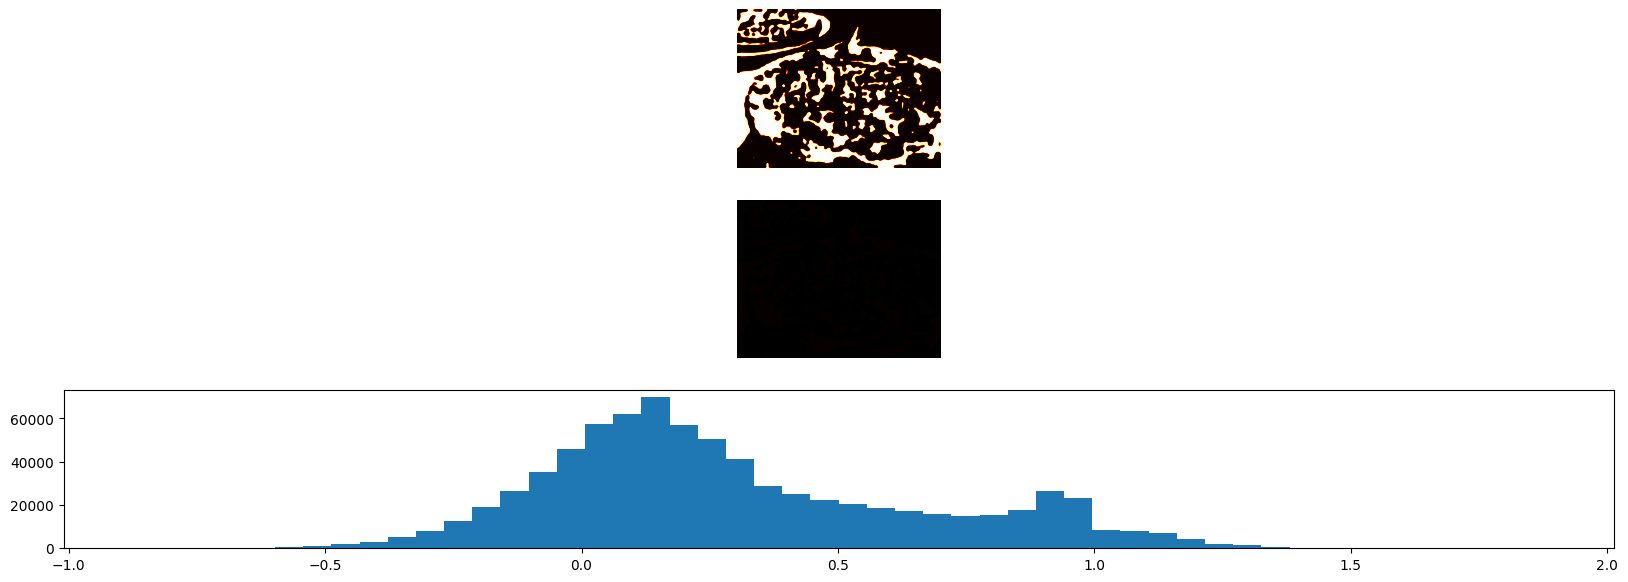

Iteration 400: -0.11550 (mse: 0.03901, aux_loss: 0.16963, p_loss: 0.05802, bce_loss: -0.38216), (lr: 0.0002572125)


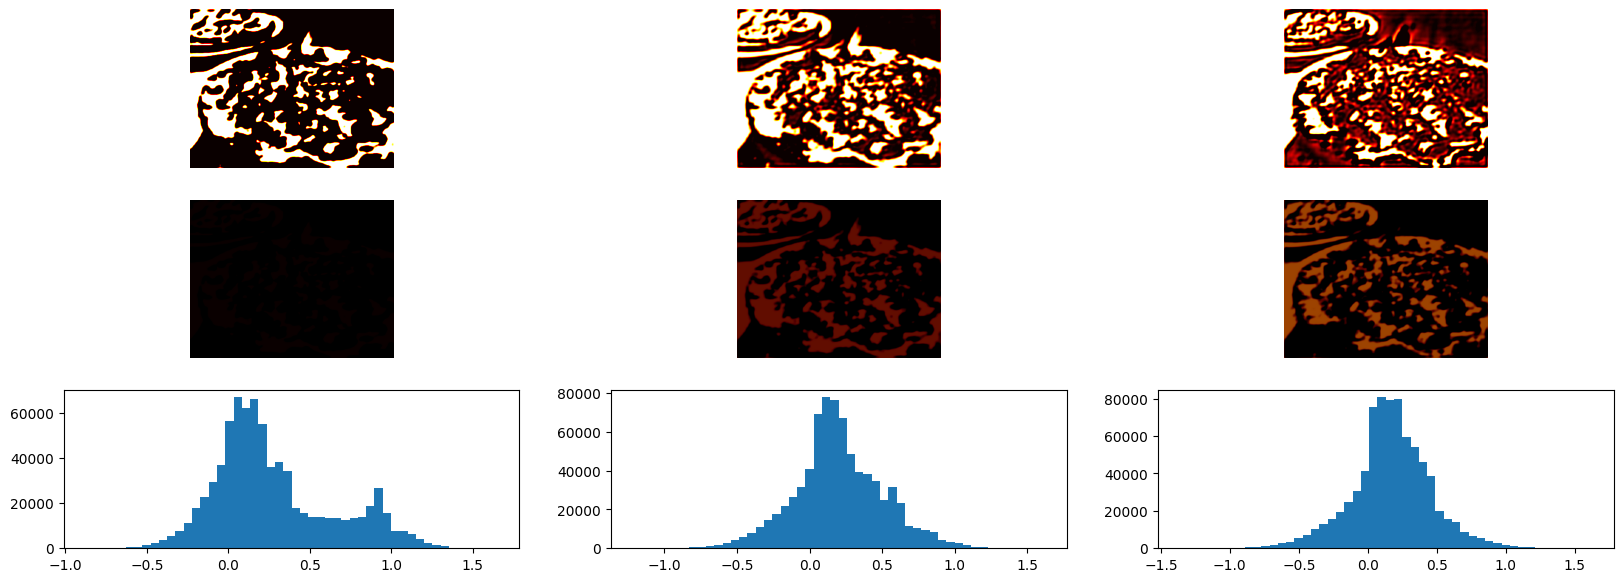

Iteration 500: -0.11741 (mse: 0.03918, aux_loss: 0.17332, p_loss: 0.05619, bce_loss: -0.38610), (lr: 0.0002572125)


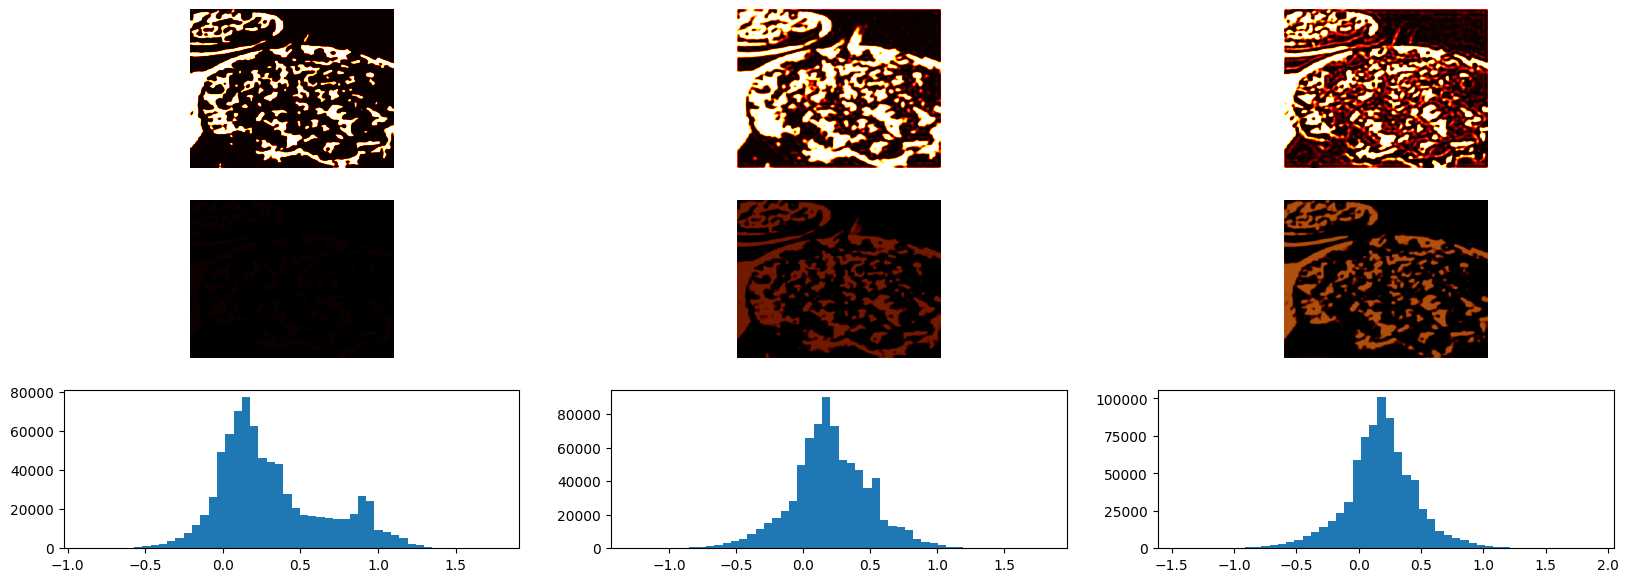

Iteration 600: -0.24326 (mse: 0.03497, aux_loss: 0.19320, p_loss: 0.05377, bce_loss: -0.52520), (lr: 0.000244351875)


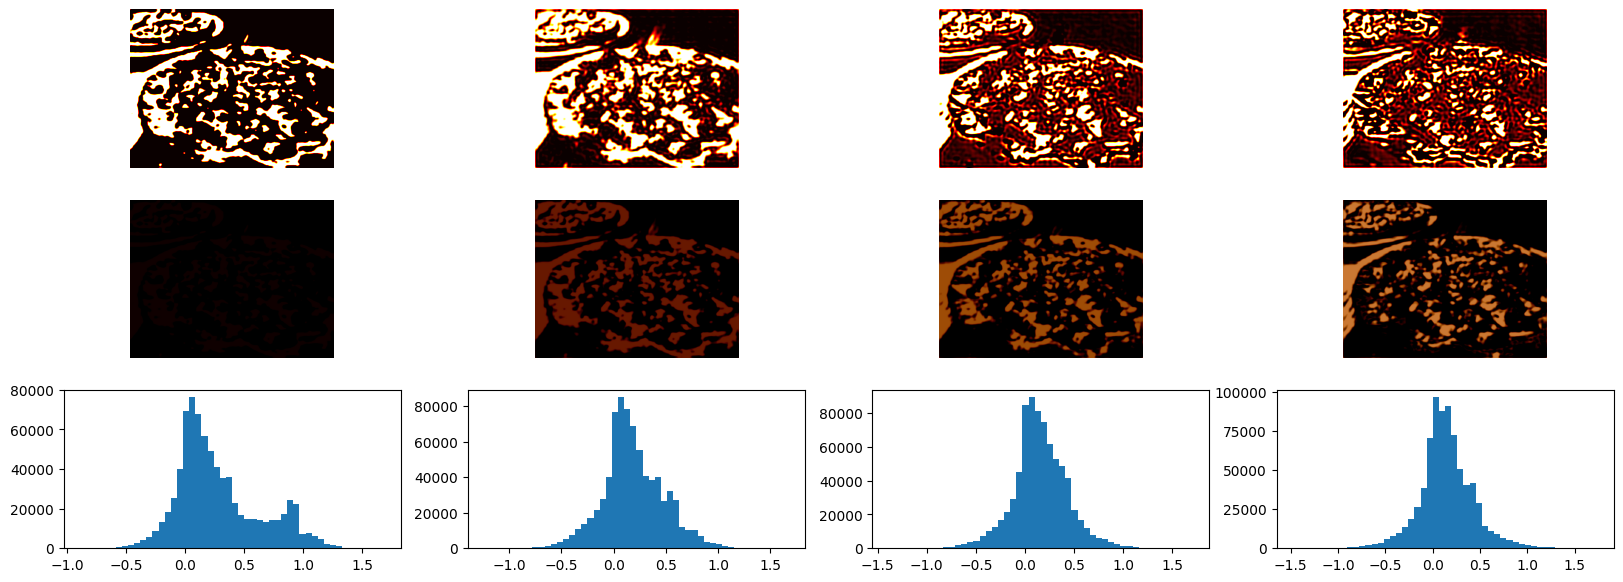

Iteration 700: -0.20018 (mse: 0.04340, aux_loss: 0.22222, p_loss: 0.06123, bce_loss: -0.52702), (lr: 0.000244351875)


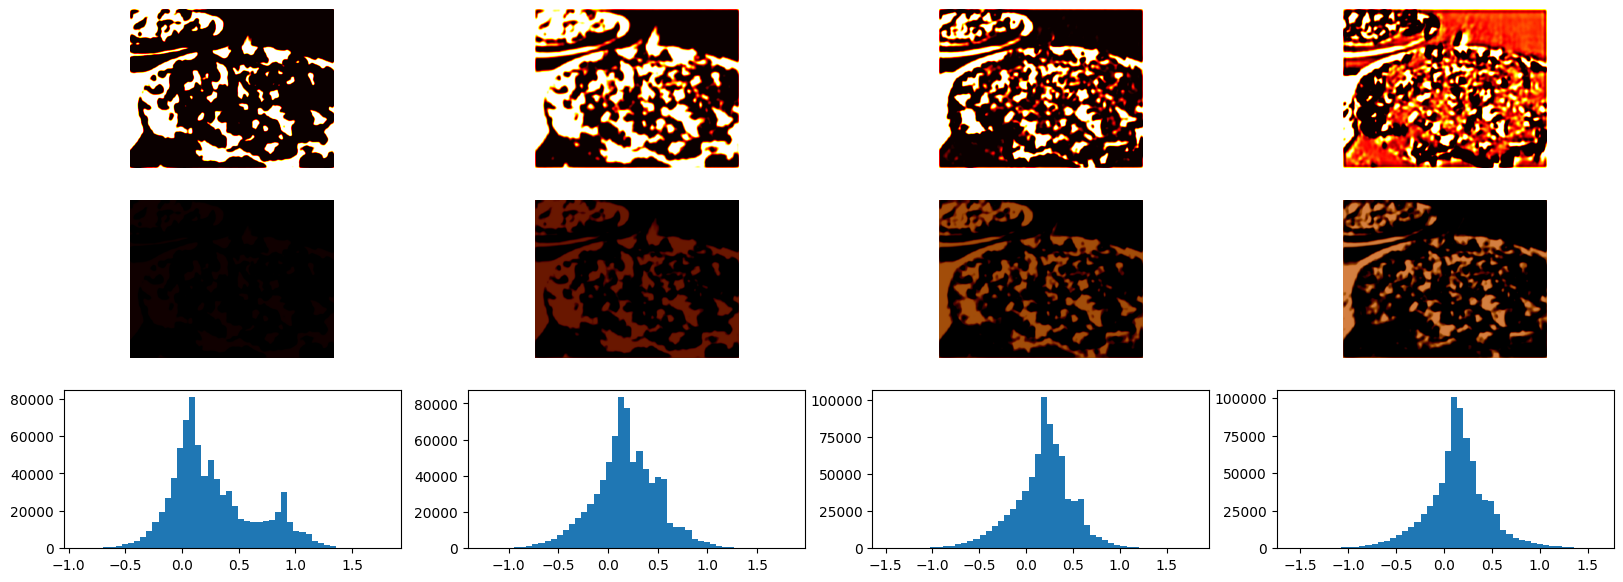

Iteration 800: -0.38338 (mse: 0.03667, aux_loss: 0.19033, p_loss: 0.05293, bce_loss: -0.66331), (lr: 0.00023213428124999998)


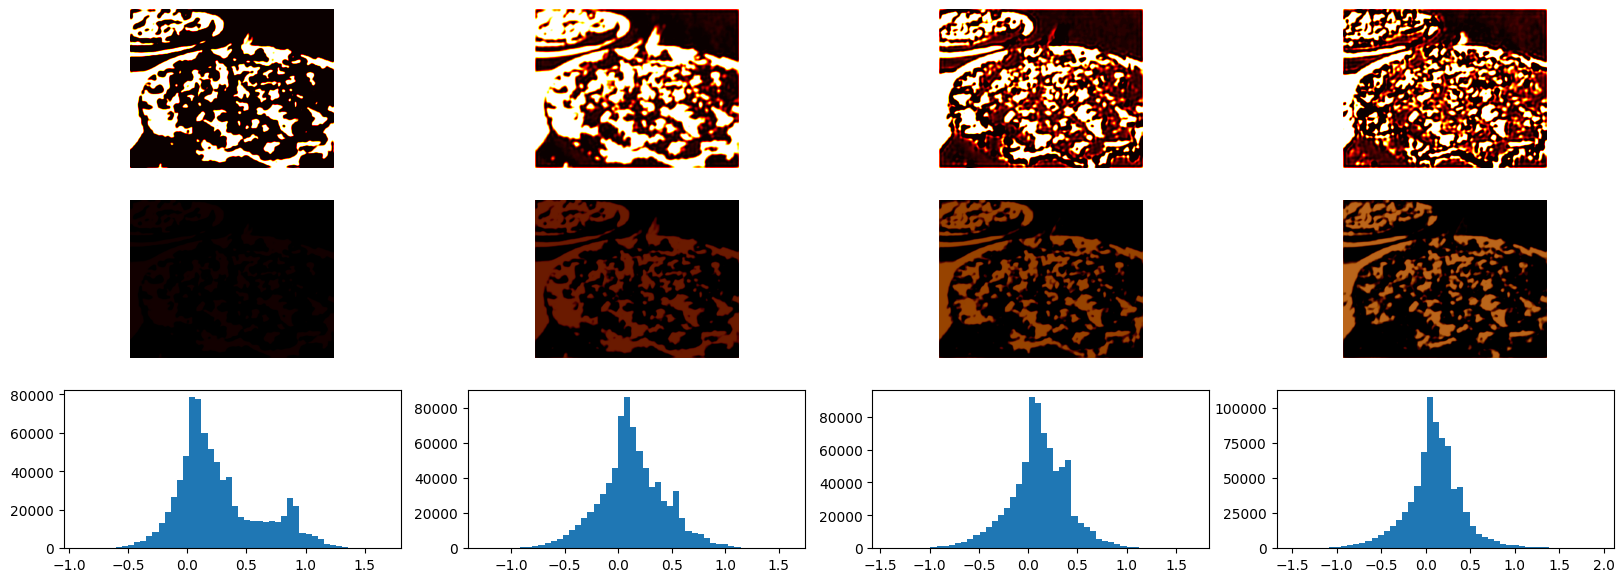

Iteration 900: -0.05553 (mse: 0.04277, aux_loss: 0.11884, p_loss: 0.05538, bce_loss: -0.27252), (lr: 0.00023213428124999998)


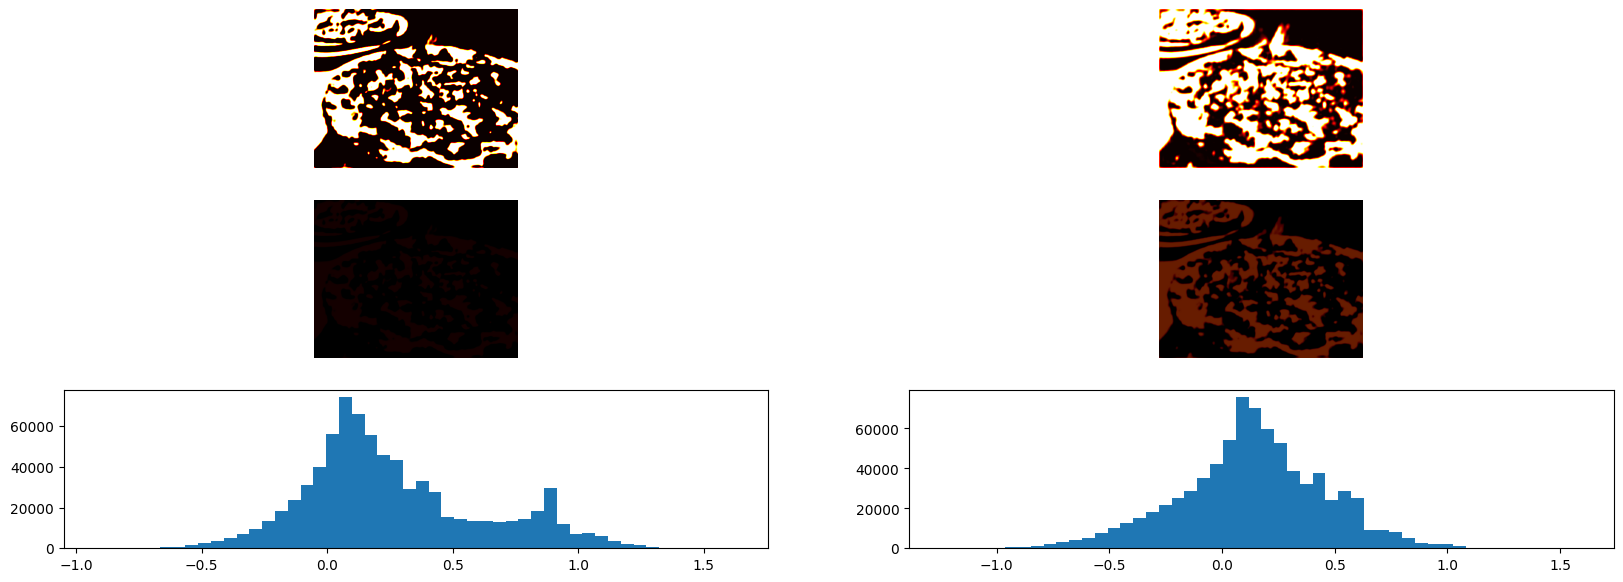

Iteration 1000: -0.06823 (mse: 0.04054, aux_loss: 0.11951, p_loss: 0.05358, bce_loss: -0.28187), (lr: 0.00022052756718749997)


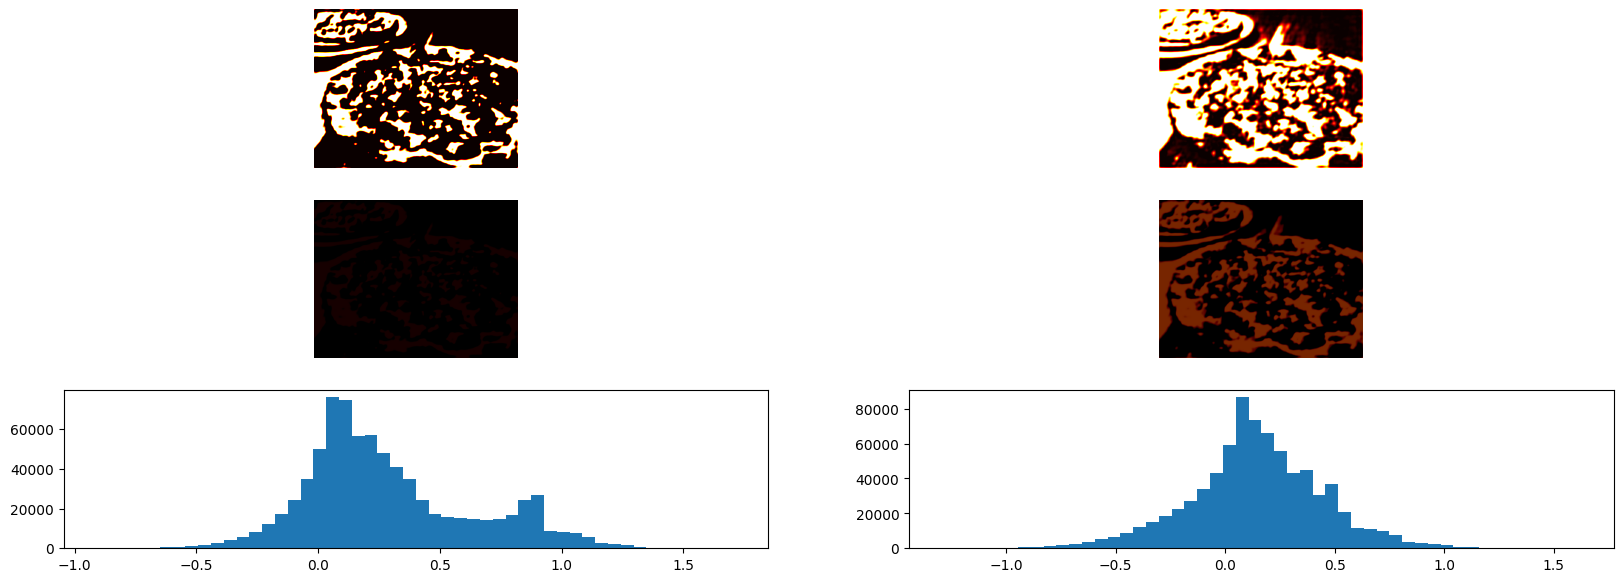

Iteration 1100: -0.09129 (mse: 0.03907, aux_loss: 0.11049, p_loss: 0.05012, bce_loss: -0.29097), (lr: 0.00022052756718749997)


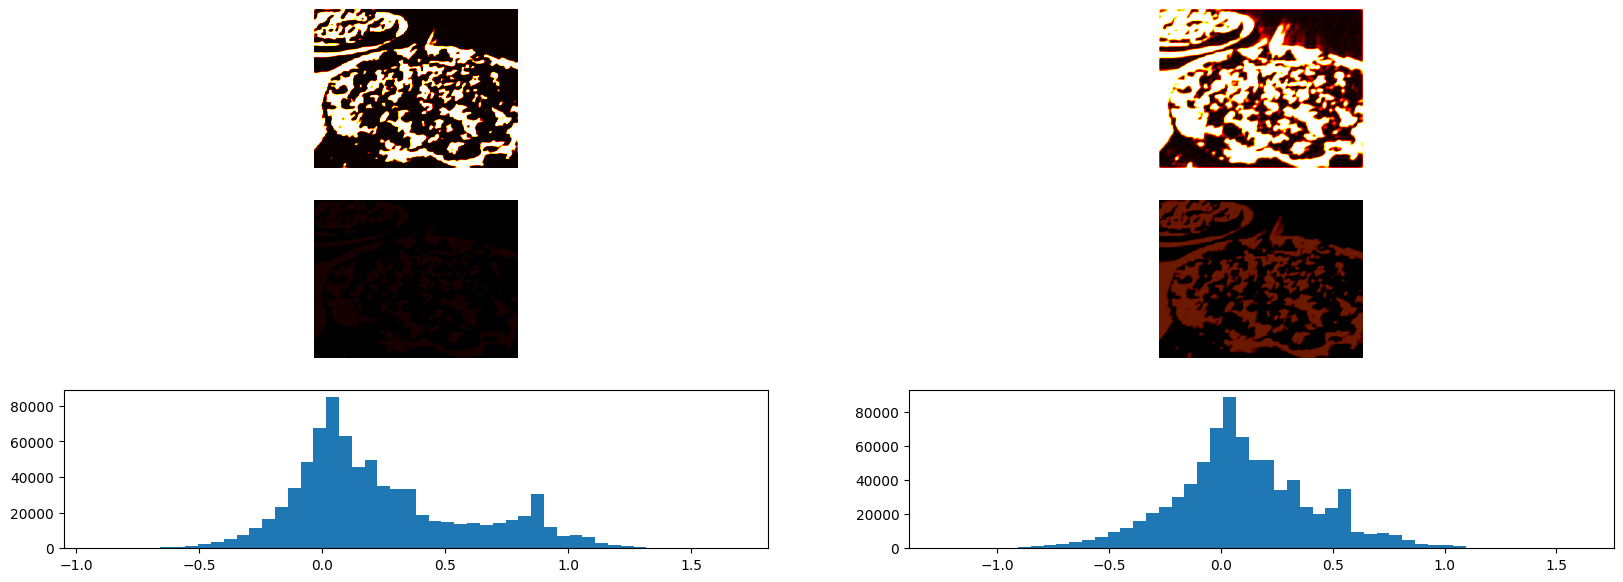

Iteration 1200: -0.45524 (mse: 0.03312, aux_loss: 0.17782, p_loss: 0.05007, bce_loss: -0.71626), (lr: 0.00020950118882812497)


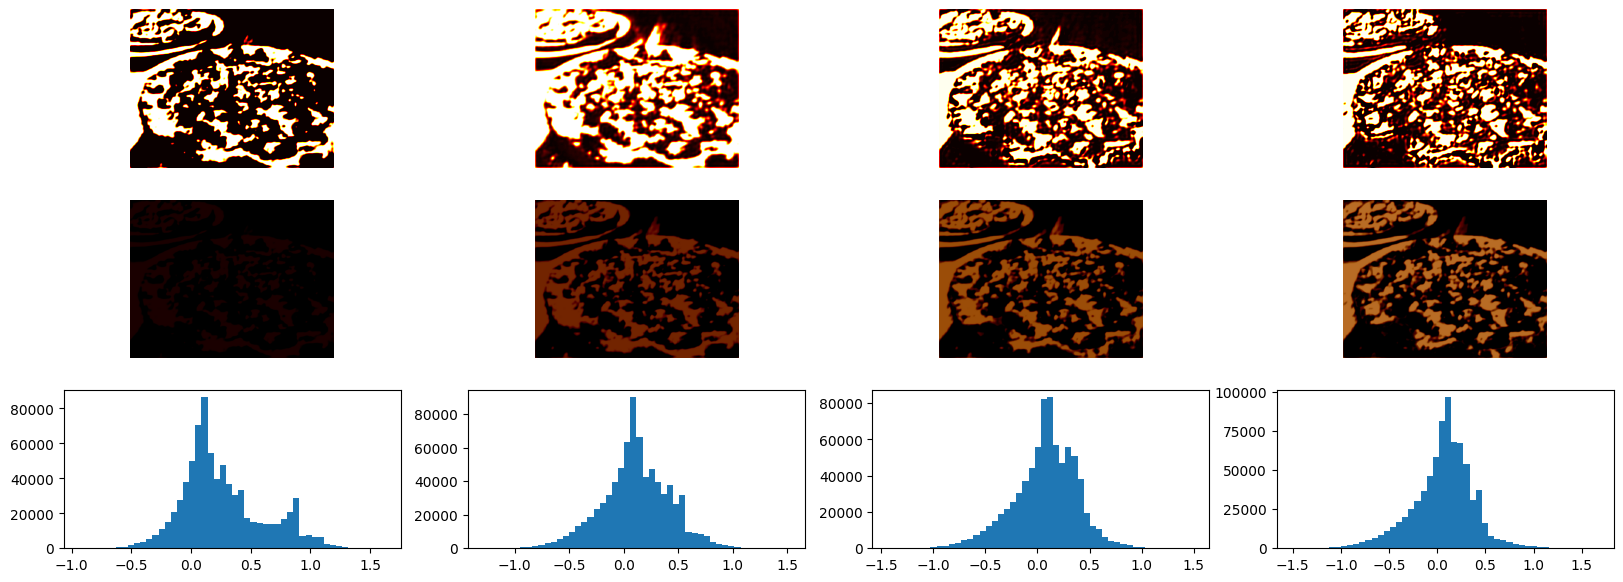

Iteration 1300: -0.41680 (mse: 0.03256, aux_loss: 0.17385, p_loss: 0.04755, bce_loss: -0.67077), (lr: 0.00020950118882812497)


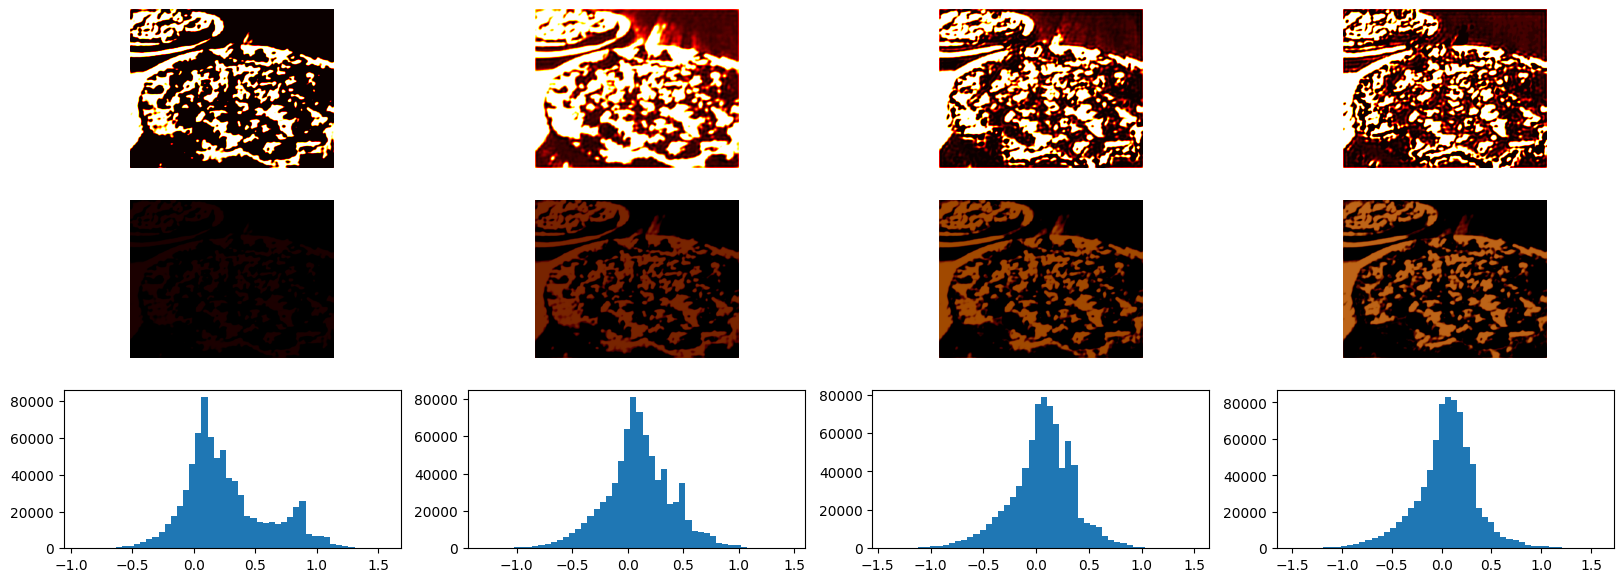

Iteration 1400: 0.19453 (mse: 0.07103, aux_loss: 0.07103, p_loss: 0.05248, bce_loss: 0.00000), (lr: 0.00019902612938671872)


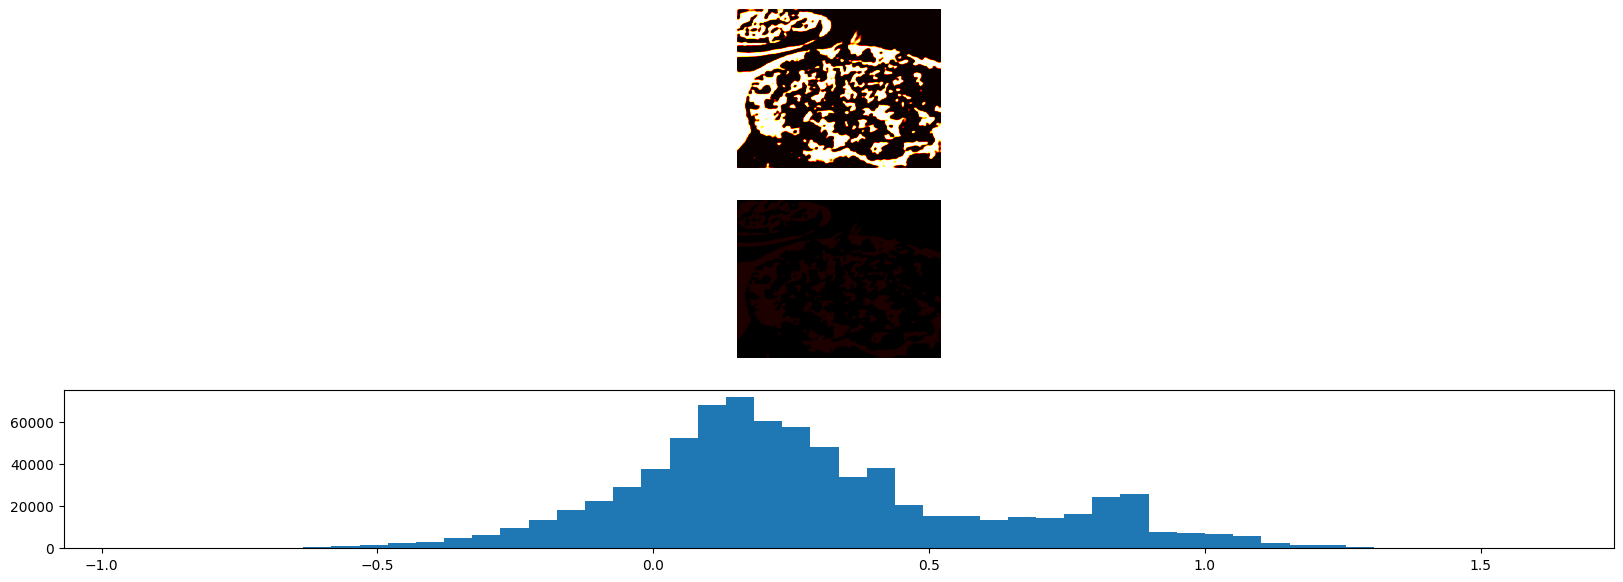

Iteration 1500: -0.28475 (mse: 0.03072, aux_loss: 0.13468, p_loss: 0.04553, bce_loss: -0.49568), (lr: 0.00019902612938671872)


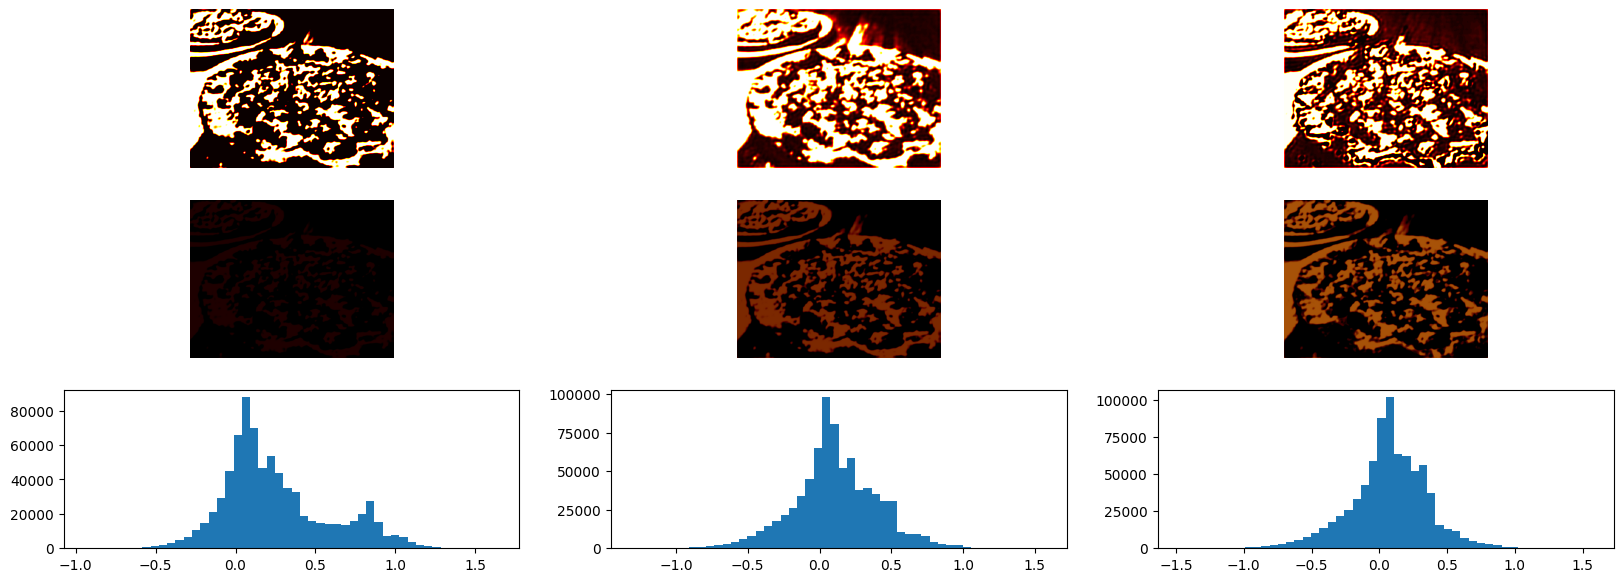

Iteration 1600: -0.09731 (mse: 0.03738, aux_loss: 0.16595, p_loss: 0.05462, bce_loss: -0.35526), (lr: 0.00018907482291738277)


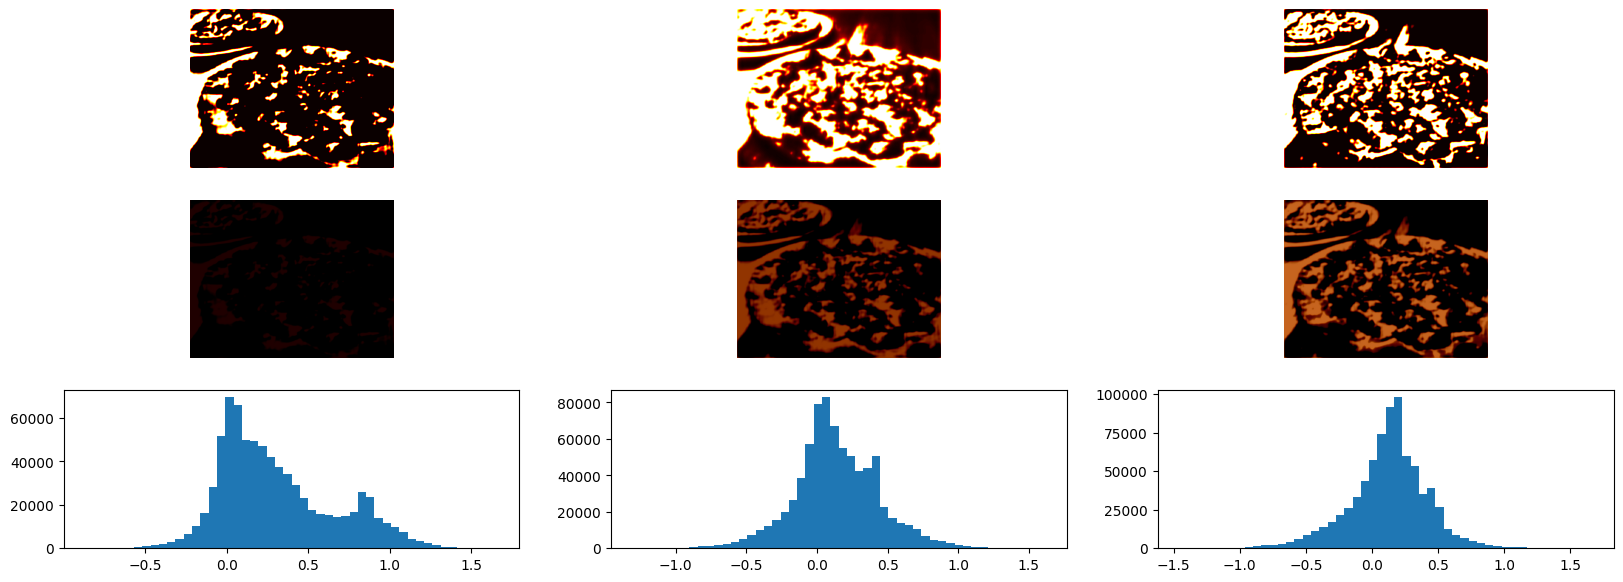

Iteration 1700: -0.09972 (mse: 0.03498, aux_loss: 0.10291, p_loss: 0.04810, bce_loss: -0.28572), (lr: 0.00018907482291738277)


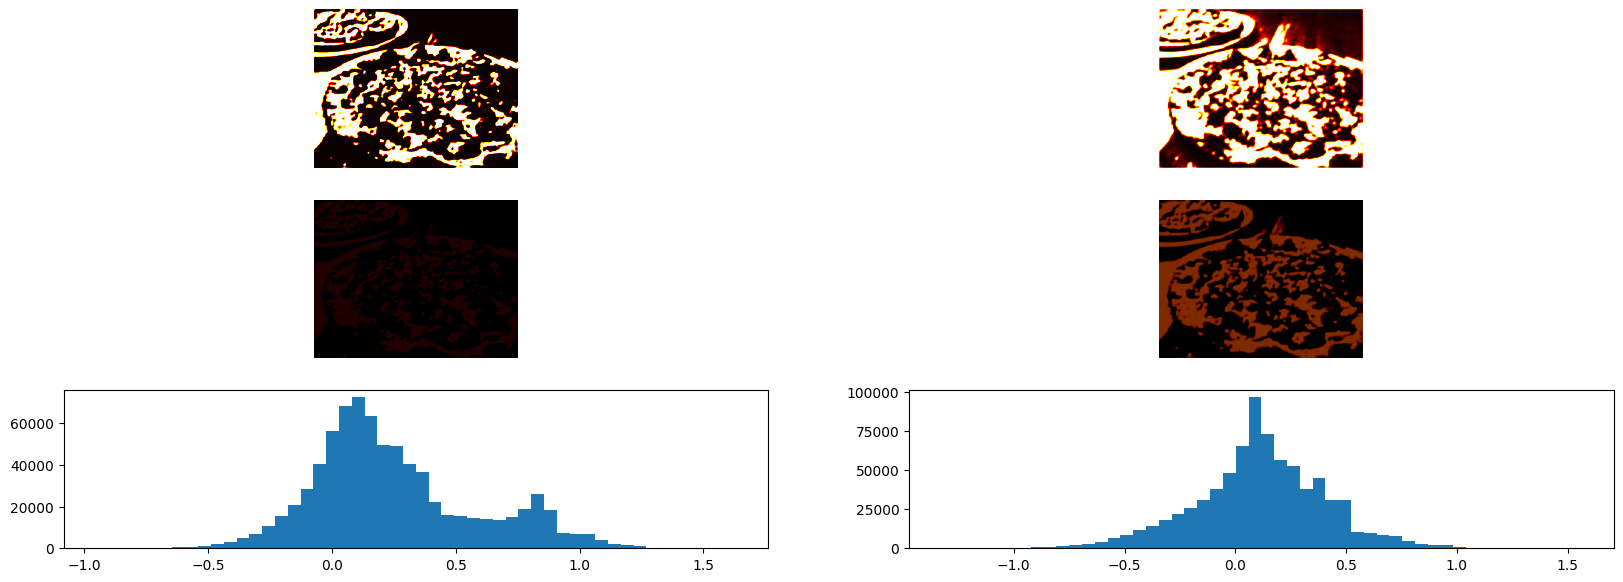

Iteration 1800: -0.26886 (mse: 0.03036, aux_loss: 0.13076, p_loss: 0.04520, bce_loss: -0.47519), (lr: 0.0001796210817715136)


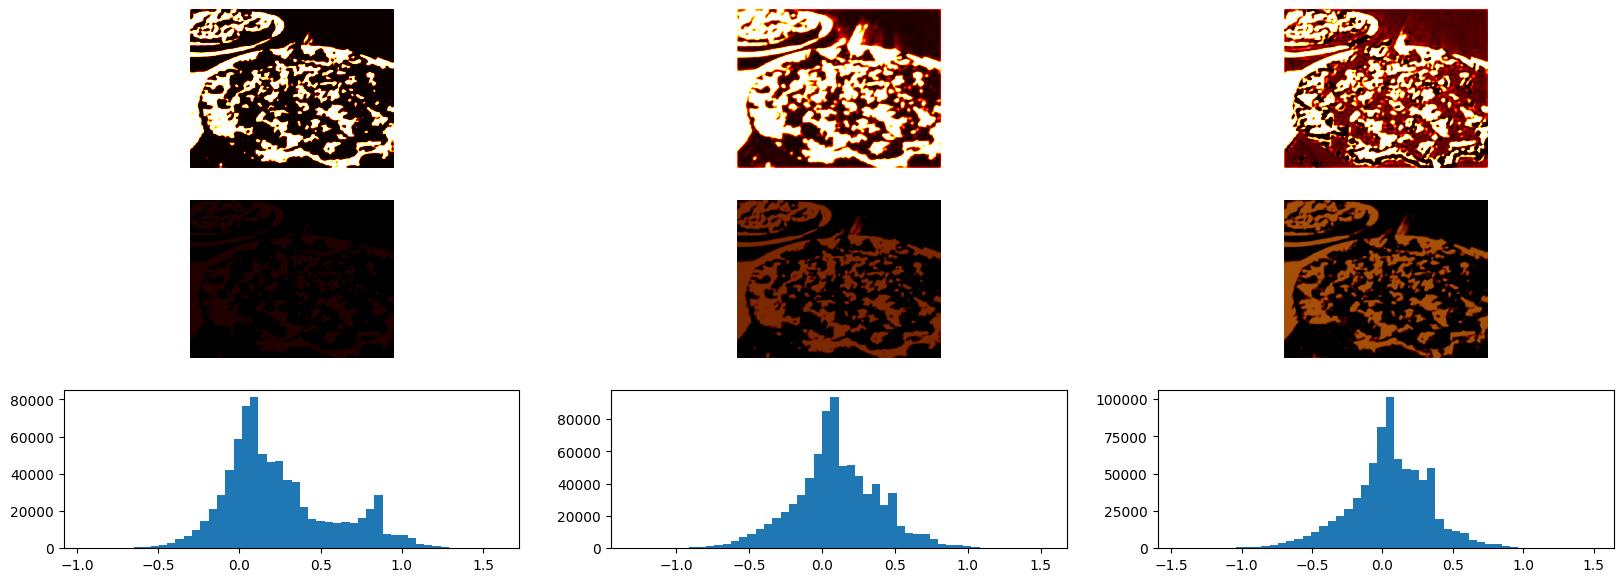

Iteration 1900: 0.17683 (mse: 0.06458, aux_loss: 0.06458, p_loss: 0.04767, bce_loss: 0.00000), (lr: 0.0001796210817715136)


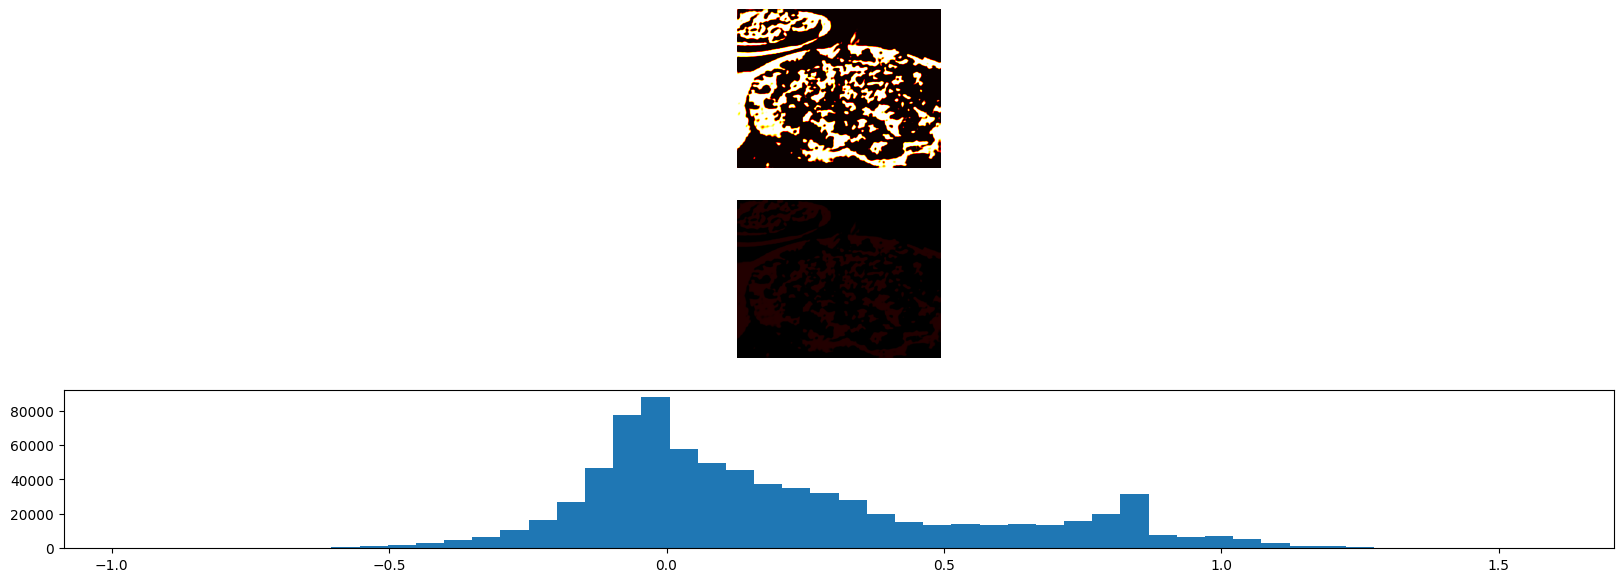

Iteration 2000: -0.11570 (mse: 0.03306, aux_loss: 0.09545, p_loss: 0.04349, bce_loss: -0.28770), (lr: 0.00017064002768293793)


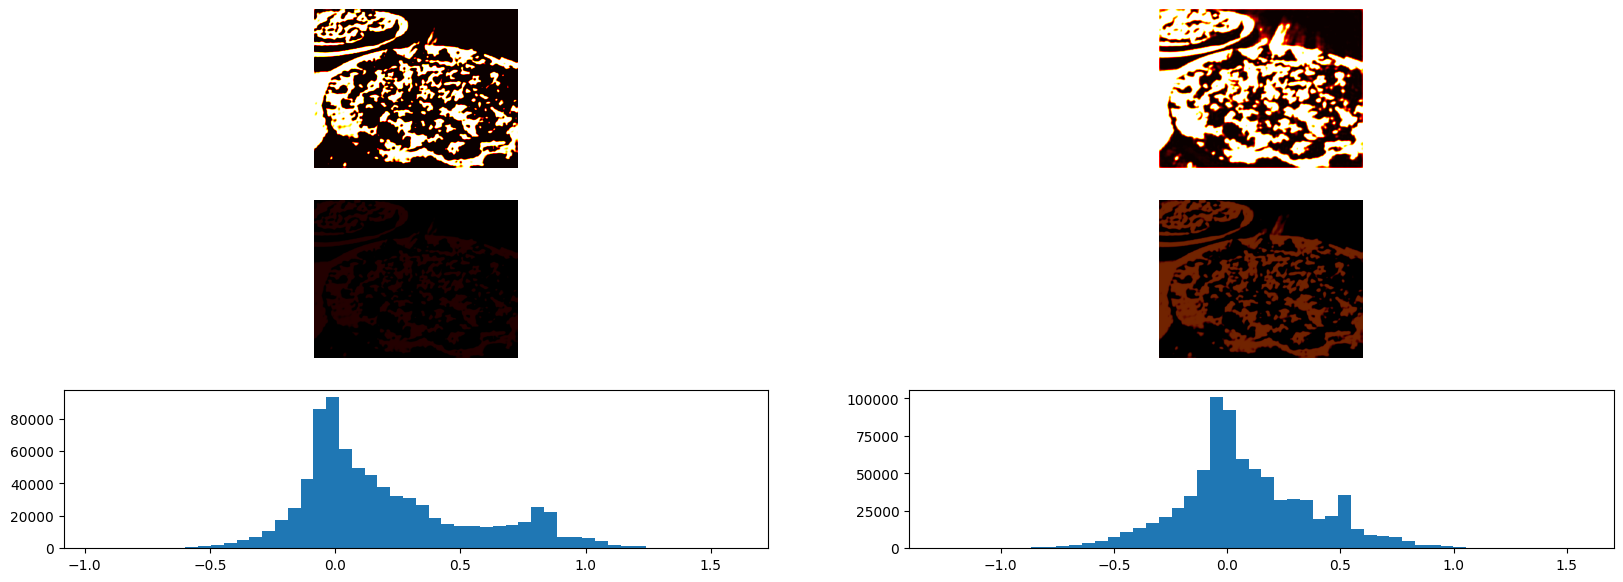

In [6]:
training_loop(batch, iters=2001, print_every_n=100, lr_update=200, warmup_token_steps=100)